# Import Libraries

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import numpy as np

# Obtain Data

Read csv file with player info into players_df, reformat 'Team' column and create 'Name-Team' column

In [2]:
players_df = pd.read_csv('players.csv')
print(players_df.shape)
players_df['Team'] = players_df['Team'].apply(lambda x: x.replace('-', ' ').title())
players_df['Name-Team'] = players_df['Name'] + ' / ' + players_df['Team']
players_df.head()

(4755, 3)


,Name,Position,Team,Name-Team
0,Corey Davis Jr.,G,Houston,Corey Davis Jr. / Houston
1,Armoni Brooks,G,Houston,Armoni Brooks / Houston
2,Galen Robinson Jr.,G,Houston,Galen Robinson Jr. / Houston
3,Nate Hinton,G,Houston,Nate Hinton / Houston
4,Dejon Jarreau,G,Houston,Dejon Jarreau / Houston


Read csv files with player stats into stats_df, reformat 'Team' column and create 'Name-Team' column

In [3]:
stats_df = pd.read_csv('stats.csv')
stats_df['Team'] = stats_df['Team'].apply(lambda x: x.replace('-', ' ').title())
stats_df['Name-Team'] = stats_df['Name'] + ' / ' + stats_df['Team']
stats_df.drop(columns=['Name','Team'], inplace=True)
print(stats_df.shape)
stats_df.head()

(4754, 25)


,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Name-Team
0,37,36,33.0,5.5,13.0,0.420,2.5,5.0,0.492,3.0,...,0.7,2.6,3.3,2.8,1.0,0.1,1.5,1.8,17.0,Corey Davis Jr. / Houston
1,37,36,30.7,4.6,11.5,0.405,1.4,3.1,0.443,3.3,...,1.1,5.2,6.3,0.9,0.8,0.3,0.9,1.6,13.4,Armoni Brooks / Houston
2,30,0,18.0,3.0,6.4,0.471,2.6,5.3,0.494,0.4,...,0.3,3.4,3.8,3.3,0.6,0.5,2.1,2.3,8.7,Dejon Jarreau / Houston
3,37,37,29.9,2.8,6.3,0.449,2.1,4.2,0.500,0.8,...,0.5,2.6,3.1,4.9,1.3,0.1,1.7,1.4,8.0,Galen Robinson Jr. / Houston
4,37,1,19.2,2.4,5.9,0.413,1.7,3.6,0.459,0.8,...,1.1,3.3,4.4,1.2,1.0,0.1,0.9,1.5,7.2,Nate Hinton / Houston


Merge tables with player data and player stats together into df

In [4]:
df = pd.merge(players_df, stats_df, how='inner', on='Name-Team')
print(df.shape)
df.head()

(4753, 28)


,Name,Position,Team,Name-Team,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Corey Davis Jr.,G,Houston,Corey Davis Jr. / Houston,37,36,33.0,5.5,13.0,0.420,...,0.869,0.7,2.6,3.3,2.8,1.0,0.1,1.5,1.8,17.0
1,Armoni Brooks,G,Houston,Armoni Brooks / Houston,37,36,30.7,4.6,11.5,0.405,...,0.630,1.1,5.2,6.3,0.9,0.8,0.3,0.9,1.6,13.4
2,Galen Robinson Jr.,G,Houston,Galen Robinson Jr. / Houston,37,37,29.9,2.8,6.3,0.449,...,0.667,0.5,2.6,3.1,4.9,1.3,0.1,1.7,1.4,8.0
3,Nate Hinton,G,Houston,Nate Hinton / Houston,37,1,19.2,2.4,5.9,0.413,...,0.857,1.1,3.3,4.4,1.2,1.0,0.1,0.9,1.5,7.2
4,Dejon Jarreau,G,Houston,Dejon Jarreau / Houston,30,0,18.0,3.0,6.4,0.471,...,0.694,0.3,3.4,3.8,3.3,0.6,0.5,2.1,2.3,8.7


# Scrub Data

Create df.info() overview of df to determine what scrubbing needed

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4753 entries, 0 to 4752
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       4753 non-null   object 
 1   Position   4751 non-null   object 
 2   Team       4753 non-null   object 
 3   Name-Team  4753 non-null   object 
 4   G          4753 non-null   int64  
 5   GS         4753 non-null   int64  
 6   MP         4753 non-null   float64
 7   FG         4753 non-null   float64
 8   FGA        4753 non-null   float64
 9   FG%        4617 non-null   float64
 10  2P         4753 non-null   float64
 11  2PA        4753 non-null   float64
 12  2P%        4502 non-null   float64
 13  3P         4753 non-null   float64
 14  3PA        4753 non-null   float64
 15  3P%        4002 non-null   float64
 16  FT         4753 non-null   float64
 17  FTA        4753 non-null   float64
 18  FT%        4262 non-null   float64
 19  ORB        4753 non-null   float64
 20  DRB     

Drop descriptive features and other features not useful for modeling position

In [6]:
df.drop(columns = ['Name', 'Team', 'Name-Team'], inplace=True)

Replace missing position values with results from looking these up in alternative sources

In [7]:
df.loc[[2830, 3597],'Position']='G'
df[df['Position'].isnull()]

,Position,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing 'FG%' values with 0 to represent that these players had not attempted any field goals

In [8]:
df['FG%'] = df['FG%'].fillna(value=0)
df[df['FG%'].isnull()]

,Position,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing '2P%' values with 0 to represent that these players had not attempted any 2P field goals

In [9]:
df['2P%'] = df['2P%'].fillna(value=0)
df[df['2P%'].isnull()]

,Position,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing '3P%' values with 0 to represent that these players had not attempted any 3P field goals

In [10]:
df['3P%'] = df['3P%'].fillna(value=0)
df[df['3P%'].isnull()]

,Position,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Replace missing 'FT%' values with 0 to represent that these players had not attempted any FTs

In [11]:
df['FT%'] = df['FT%'].fillna(value=0)
df[df['FT%'].isnull()]

,Position,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS


Update Positional string values to numerical values and merge the single instance of 'D' class into 'C' class based on player research in alternative sources

In [12]:
position_dict = {'G': 0, 'F': 1, 'C': 1, 'D': 1}
df['Position'] = df['Position'].replace(position_dict)
df['Position'].value_counts()


0    2767
1    1986
Name: Position, dtype: int64

Final df.info() overview of data after scrubbing

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4753 entries, 0 to 4752
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Position  4753 non-null   int64  
 1   G         4753 non-null   int64  
 2   GS        4753 non-null   int64  
 3   MP        4753 non-null   float64
 4   FG        4753 non-null   float64
 5   FGA       4753 non-null   float64
 6   FG%       4753 non-null   float64
 7   2P        4753 non-null   float64
 8   2PA       4753 non-null   float64
 9   2P%       4753 non-null   float64
 10  3P        4753 non-null   float64
 11  3PA       4753 non-null   float64
 12  3P%       4753 non-null   float64
 13  FT        4753 non-null   float64
 14  FTA       4753 non-null   float64
 15  FT%       4753 non-null   float64
 16  ORB       4753 non-null   float64
 17  DRB       4753 non-null   float64
 18  TRB       4753 non-null   float64
 19  AST       4753 non-null   float64
 20  STL       4753 non-null   floa

# Explore data

Calculate class weights

In [14]:
print(df['Position'].value_counts())
df['Position'].value_counts()/df['Position'].count()

0    2767
1    1986
Name: Position, dtype: int64


0    0.582159
1    0.417841
Name: Position, dtype: float64

Plot clas weights

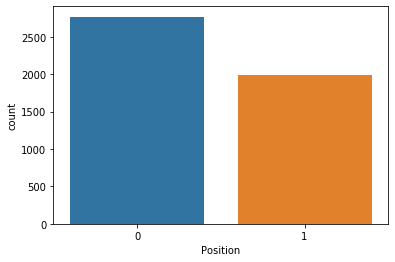

In [15]:
sns.countplot(x='Position',data=df)

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


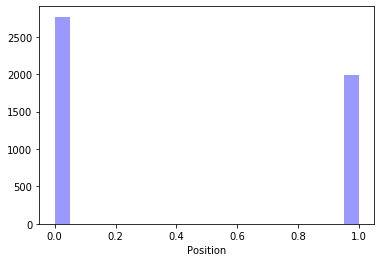

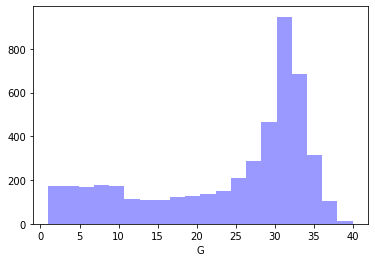

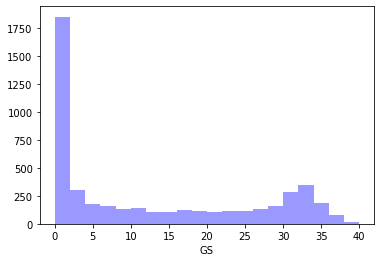

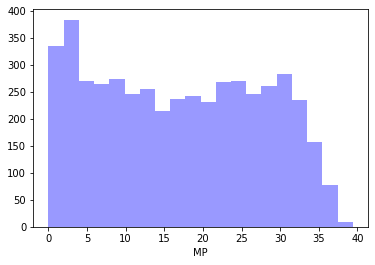

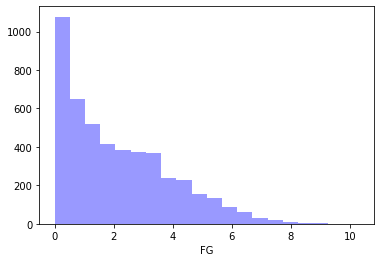

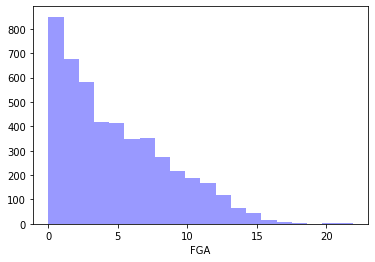

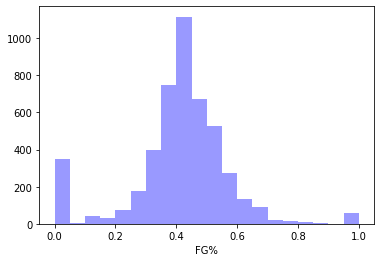

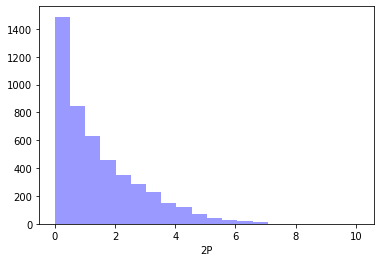

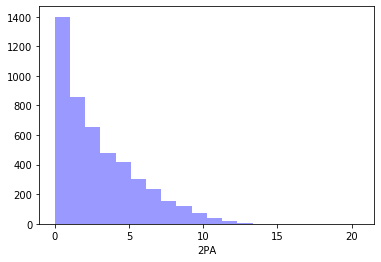

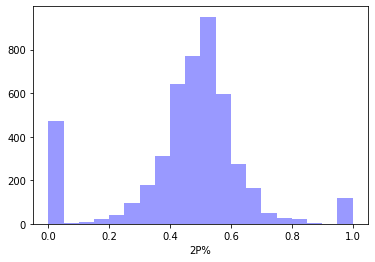

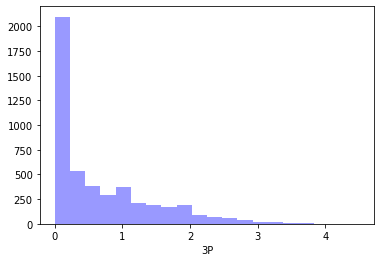

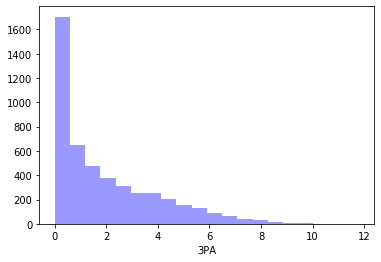

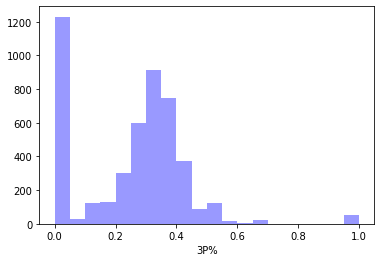

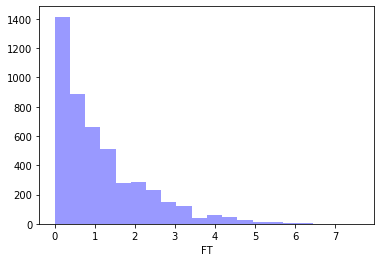

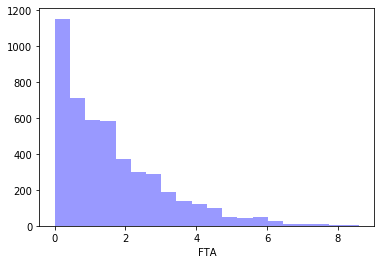

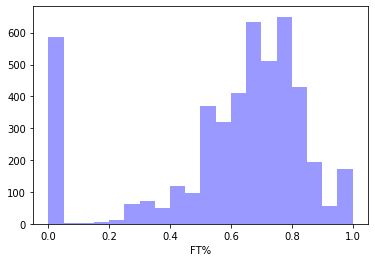

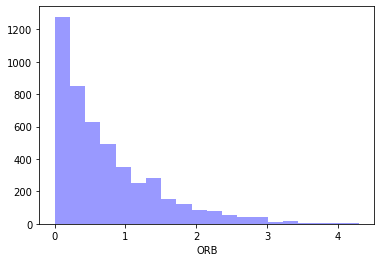

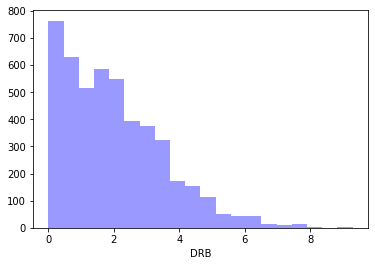

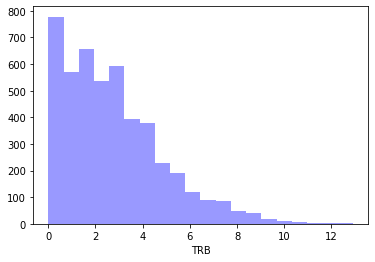

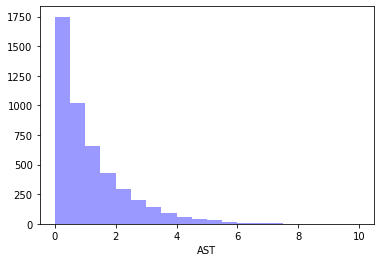

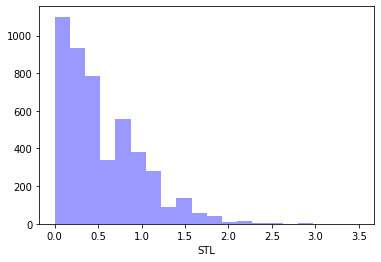

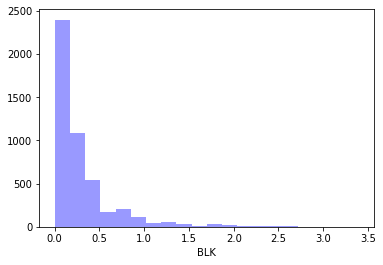

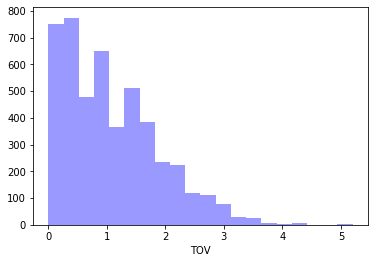

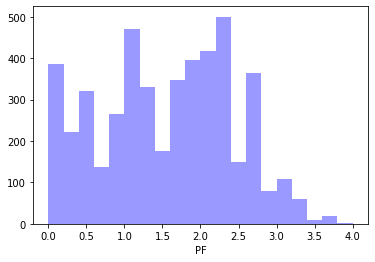

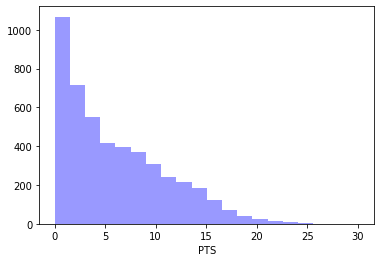

In [16]:
for feature in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feature], kde=False, bins=20, color='blue', ax=ax)

# Pre-Modeling

Downsample 0 class to achieve class balance

In [17]:
zero_df = df[df['Position']==0]
one_df = df[df['Position']==1]
downsampled_zero_df = resample(zero_df, replace=False, n_samples = 1986, random_state = 50)
df = pd.concat([downsampled_zero_df, one_df])
df.reset_index(inplace=True, drop=True)
print(df.shape)
print(df[df['Position']==0].shape)
print(df[df['Position']==1].shape)
df.iloc[1984:1989]

(3972, 25)
(1986, 25)
(1986, 25)


,Position,G,GS,MP,FG,FGA,FG%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1984,0,30,18,28.1,4.1,9.5,0.427,2.6,5.3,0.500,...,0.804,1.6,2.3,3.9,1.2,0.6,0.3,1.7,2.1,12.2
1985,0,28,0,11.3,1.2,2.5,0.479,1.0,1.9,0.538,...,0.724,0.2,0.7,0.9,0.7,0.3,0.1,0.9,0.7,3.4
1986,1,37,36,13.9,2.5,4.3,0.581,2.5,4.3,0.581,...,0.632,1.5,2.5,4.0,0.4,0.5,0.6,1.0,3.2,6.0
1987,1,32,21,18.4,2.5,5.4,0.457,2.5,5.4,0.459,...,0.672,1.9,2.1,4.0,0.7,0.4,0.6,1.0,2.8,6.3
1988,1,37,16,18.0,1.5,4.4,0.348,0.7,1.2,0.556,...,0.763,1.0,2.0,2.9,0.7,0.5,0.2,0.7,1.2,4.6


# Modeling

Create x and y variables from df

In [18]:
x_cols = df.columns[4:]
x = df[x_cols]
y = df['Position']

Apply train test split to data

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 94)

Apply standard scaler to data

In [20]:
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train)
x_test = ss.transform(x_test)
x_train = pd.DataFrame(x_train, columns = x.columns)
x_test = pd.DataFrame(x_test, columns = x.columns)
x_train.head()

,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,3P%,FT,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0.639001,0.699967,0.120062,0.641358,0.902751,-0.042200,0.298864,0.142094,0.795291,0.002911,...,-0.024887,-0.235484,0.313958,0.148875,0.150914,-0.010590,-0.495245,0.186680,0.516362,0.496699
1,-0.894225,-0.945481,0.102167,-0.701164,-0.702239,-0.148827,-0.807286,-0.894375,-1.299230,-0.359715,...,-0.211228,-0.372681,-0.639501,-0.586986,-0.835983,-0.907811,-0.007220,-0.433051,-0.497046,-0.828602
2,0.355070,0.593809,-0.142389,0.005427,0.062042,-0.001581,0.990208,1.023093,0.500666,-0.087746,...,0.286950,-0.647074,0.059702,-0.173064,0.778939,-0.010590,-0.495245,0.310626,0.065958,0.376217
3,-0.667081,-0.680086,0.048484,-0.418527,-0.358312,-0.158982,-0.807286,-0.894375,-1.299230,-0.722341,...,-0.595320,0.862089,-0.130989,0.194866,-0.656547,-0.010590,0.724818,-0.804890,0.741563,-0.748281
4,-0.156006,0.089559,-0.309403,-0.065232,0.100256,-0.133595,-0.254211,0.038448,-0.024304,1.725383,...,0.678647,-0.098288,-0.321681,-0.265047,1.227528,0.886631,-0.739257,0.806411,0.291160,0.255735


Build baseline model

In [21]:
dc = DummyClassifier(strategy='stratified', random_state=73)
dc.fit(x_train, y_train)
y_test_pred_dc = dc.predict(x_test)
y_train_pred_dc = dc.predict(x_train)
print('Train f1 score', f1_score(y_train, y_train_pred_dc))
print('Test f1 score', f1_score(y_test, y_test_pred_dc))

Train f1 score 0.5087829360100377
Test f1 score 0.5256410256410257


Gridsearch KNN Model params

In [22]:
knn_param_grid = {'n_neighbors': range(1,51), 'weights':['uniform', 'distance']}
knn_gs_model = KNeighborsClassifier()
knn_gs = GridSearchCV(knn_gs_model, knn_param_grid, scoring='f1', n_jobs=-1, cv=10, verbose=1)
knn_gs.fit(x_train, y_train)
print('Best params:', knn_gs.best_params_)
print('Best estimator:', knn_gs.best_estimator_)
print('Best score: ', knn_gs.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s


KeyboardInterrupt: 

Build KNN Model

In [30]:
knn =  KNeighborsClassifier(n_neighbors=27)
knn.fit(x_train, y_train)
y_train_pred_knn = knn.predict(x_train)
y_test_pred_knn = knn.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_knn, ))
print('Test f1 Score', f1_score(y_test, y_test_pred_knn))

Train f1 Score 0.8436173685928828
Test f1 Score 0.8374512353706113
Accuracy 0.8427672955974843


[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

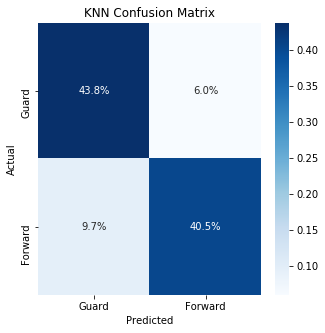

In [35]:
knn_cm = confusion_matrix(y_test, y_test_pred_knn)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(knn_cm/np.sum(knn_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('KNN Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch Random Forest params

In [ ]:
rf_param_grid = {'max_depth':range(10,20), 'min_samples_split': range(5,15)}
rf_gs_model = RandomForestClassifier()
rf_gs = GridSearchCV(rf_gs_model, rf_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)
print('Best params:', rf_gs.best_params_)
print('Best estimator:', rf_gs.best_estimator_)
print('Best score: ', rf_gs.best_score_)

Build Random Forest model

In [24]:
rf =  RandomForestClassifier(max_depth=11, min_samples_split=10)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_rf))
print('Test f1 Score', f1_score(y_test, y_test_pred_rf))

Train f1 Score 0.9547770700636942
Test f1 Score 0.8472400513478818


[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

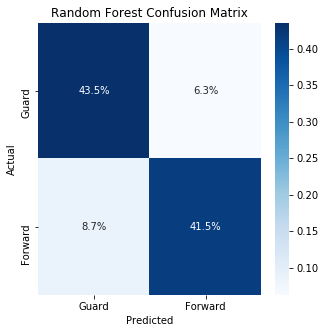

In [36]:
rf_cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(rf_cm/np.sum(rf_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Random Forest Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch Adaboost parameters

In [ ]:
ab_param_grid = {'learning_rate': [x/100 for x in range (40,81)]}
ab_gs_model = AdaBoostClassifier()
ab_gs = GridSearchCV(ab_gs_model, ab_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)
print('Best params:', ab_gs.best_params_)
print('Best estimator:', ab_gs.best_estimator_)
print('Best score: ', ab_gs.best_score_)

Build Adaboost model

In [25]:
ab =  AdaBoostClassifier(learning_rate = .7)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_ab))
print('Test f1 Score', f1_score(y_test, y_test_pred_ab))

Train f1 Score 0.8576020572163291
Test f1 Score 0.8482490272373541


[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

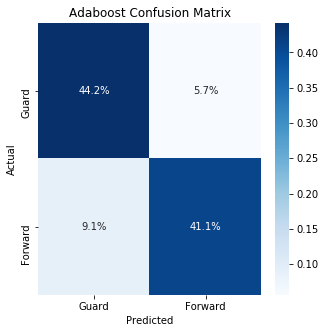

In [37]:
ab_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(ab_cm/np.sum(ab_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Adaboost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Gridsearch XG Boost Model

In [103]:
xgb_param_grid = {'max_depth': range(1,6), 'gamma': [.000001, .00001, .0001, .001, .1]}
xgb_gs_model = XGBClassifier(lr=.01, booster='gbtree')
xgb_gs = GridSearchCV(xgb_gs_model, xgb_param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
xgb_gs.fit(x_train, y_train)
print('Best params:', xgb_gs.best_params_)
print('Best estimator:', xgb_gs.best_estimator_)
print('Best score: ', xgb_gs.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.6min finished


[21:50:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best params: {'gamma': 1e-06, 'max_depth': 1}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1e-06, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, lr=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_met

Build Gradient Boost Model

In [106]:
xgb = XGBClassifier(max_depth=1, lr=.01, booster='gbtree')
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('Train F1 Score: ', f1_score(y_train, y_train_pred_xgb))
print('Test F1 Score: ', f1_score(y_test, y_test_pred_xgb))

[21:51:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train F1 Score:  0.8620466321243524
Test F1 Score:  0.851994851994852


[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

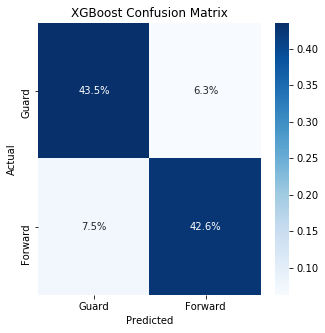

In [67]:
xgb_cm = confusion_matrix(y_test, y_test_pred_xgb)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(xgb_cm/np.sum(xgb_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('XGBoost Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])

Build voting classifier

In [107]:
knn_vc =  KNeighborsClassifier(n_neighbors=27)
rf_vc = RandomForestClassifier(max_depth=11, min_samples_split=10)
ab_vc = AdaBoostClassifier(learning_rate = .7)
xgb_vc = XGBClassifier(max_depth=1, lr=.01, booster='gbtree')
vc= VotingClassifier([('rf', rf_vc), ('ab', ab_vc), ('xgb', xgb_vc)], voting='soft')
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Train f1 Score', f1_score(y_train, y_train_pred_vc))
print('Test f1 Score', f1_score(y_test, y_test_pred_vc))

[21:54:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train f1 Score 0.9051612903225807
Test f1 Score 0.8527131782945736


[Text(0, 0.5, 'Guard'), Text(0, 1.5, 'Forward')]

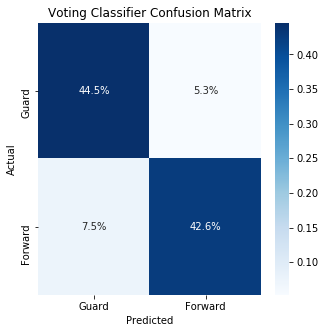

In [53]:
xgb_vc = confusion_matrix(y_test, y_test_pred_vc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(xgb_vc/np.sum(xgb_vc), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Voting Classifier Confusion Matrix')
matrix.set_xlabel('Predicted')
matrix.set_xticklabels(['Guard','Forward'])
matrix.set_ylabel('Actual')
matrix.set_yticklabels(['Guard','Forward'])